# Doing as per point scoring system of dream 11<br>

How are Dream11 points calculated?


Dream11 points are calculated on the basis of the performance of the player in the real T20 match. Here is a breakdown of the calculation.<br>


Batting points


1 point per run<br>
1 point per boundary bonus<br>
2 points per six scored<br>
4 points for scoring 30 runs<br>
8 points for a half-century<br>
16 points for a century<br>
-2 points if dismissed for a duck (Only for batsmen, wicket-keepers, and all-rounders)<br><br>


Bowling points


25 points per wicket, excluding run-outs<br>
8 bonus points for taking the wicket by LBW or Bowled<br>
4 bonus points for taking three wickets in a single match<br>
8 bonus points for taking four wickets in a single match<br>
16 bonus points for taking five wickets in a single match<br>
12 points per maiden over<br><br>


Fielding points


8 points per catch<br>
4 bonus points for taking three catches in one match<br>
12 points per stump/direct run-out<br>
6 points per throw leading to a run-out<br>
6 points per catch leading to a run-out<br><br>

Other points<br>

Captain of the Dream11 team - 2x the points scored in the match
Vice-captain of the Dream11 team - 1.5x the points scored in the match
4 points each for every player announced in the playing XI<br><br>


Economy rate points<br>


6 points if his economy rate is below 5 runs per over<br>
4 points if his economy rate is between 5 - 5.99 runs per over<br>
2 points if his economy rate is between 6 - 7 runs per over<br>
-2 points if his economy rate is between 10 - 11 runs per over<br>
-4 points if his economy rate is between 11.01 - 12 runs per over<br>
-6 points if his economy rate is above 12 runs per over<br>


The economy rate comes into consideration for Dream11 points only after a bowler has bowled at least two overs.



Strike rate points


-2 points if his Strike Rate is between 60 - 70<br>
-4 points if his Strike Rate is between 50 - 50.99<br>
-6 points if his Strike Rate is below 50<br>
+2 points if his Strike Rate is between 130-150<br>
+4 points if his Strike Rate is between 150.01-170<br>
+6 points if his Strike Rate is more than 170<br>


Strike rate points are not calculated for the player who is in the lineup as a specialist bowler.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("./bowling_custom2.csv")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["time_value"] = df["year"] - 2017
df = df.drop(["date", "match_id", "year"], axis=1)
df["economy_rate"] = df["runs_conceded"] / (df["balls_bowled"] / 6)
df.head()

,bowler,wickets,wicket_score,balls_bowled,runs_conceded,maiden,time_value,economy_rate
0,UT Yadav,0,0,18,35,0,6,11.666667
1,D Wiese,0,0,18,38,0,6,12.666667
2,CV Varun,1,25,24,49,0,6,12.250000
3,K Khejroliya,2,50,18,44,0,6,14.666667
4,SP Narine,0,0,12,23,0,6,11.500000


In [3]:
df_train = df[(df["time_value"] < 6)].copy()
df_test = df[(df["time_value"] == 6)].copy()
df_mean = df_train.groupby("bowler").mean().reset_index()

# df_mean = df_train[["wickets", "time_value", "balls_bowled", "runs_conceded"]]

# df_mean = (
#     df_train.groupby("bowler")
#     .apply(
#         lambda group: np.average(
#             group[["wickets", "time_value", "balls_bowled", "runs_conceded"]],
#             weights=group["time_value"],
#             axis=0,
#         )
#     )
#     .reset_index(name="weighted_mean")
# )

# df_mean[["wickets", "time_value", "balls_bowled", "runs_conceded"]] = pd.DataFrame(
#     df_mean["weighted_mean"].tolist(), index=df_mean.index
# )
# df_mean = df_mean.drop("weighted_mean", axis=1)

df_mean.head()

,bowler,wickets,wicket_score,balls_bowled,runs_conceded,maiden,time_value,economy_rate
0,A Badoni,1.000000,29.000000,6.000000,5.500000,0.0,5.000000,5.500000
1,A Dananjaya,0.000000,0.000000,24.000000,47.000000,0.0,1.000000,11.750000
2,A Mishra,1.192308,30.692308,21.461538,24.923077,0.0,1.961538,6.987179
3,A Nortje,1.517241,40.655172,22.689655,30.448276,0.0,3.689655,8.181650
4,A Zampa,0.500000,12.500000,21.000000,19.500000,0.0,3.000000,6.000000


In [4]:
def calculate_economy_rate_score(economy_rate):
    if economy_rate < 5:
        return 6
    elif 5 <= economy_rate <= 5.99:
        return 4
    elif 6 <= economy_rate <= 7:
        return 2
    elif 10 <= economy_rate <= 11:
        return -2
    elif 11.01 <= economy_rate <= 12:
        return -4
    else:
        return -6


df_train["economy_rate_score"] = df_train["economy_rate"].apply(
    calculate_economy_rate_score
)

df_test["economy_rate_score"] = df_test["economy_rate"].apply(
    calculate_economy_rate_score
)

# df_mean["economy_rate_score"] = df_mean["economy_rate"].apply(
#     calculate_economy_rate_score
# )

In [5]:
w1, w2, w3, w4 = 1, 1.6, 1, 12
weighted_score_train = (
    w1 * df_train["wicket_score"]
    + w2 ** df_train["time_value"]
    + w3 * df_train["economy_rate_score"]
    + w4 * df_train["maiden"]
)

weighted_score_test = (
    w1 * df_test["wicket_score"]
    + w2 ** df_test["time_value"]
    + w3 * df_test["economy_rate_score"]
    + w4 * df_test["maiden"]
)

In [6]:
selected_cols = ["wickets", "time_value", "balls_bowled", "runs_conceded"]
X_train = df_train[selected_cols]
y_train = weighted_score_train

X_test = df_mean[selected_cols]

X_test1 = df_test[selected_cols]
y_test1 = weighted_score_test
X_train.head()

,wickets,time_value,balls_bowled,runs_conceded
13,1,4,24,19
14,3,4,24,15
15,1,4,24,41
16,0,4,24,33
17,3,4,24,21


In [7]:
model = LinearRegression()

In [8]:
model.fit(X_train, y_train)

LinearRegression()

In [9]:
y_pred = model.predict(X_test)
y_pred1 = model.predict(X_test1)

In [10]:
mse = mean_squared_error(y_test1, y_pred1)
mse

103.63095309907665

In [11]:
print(len(df_mean), len(y_pred))

220 220


In [72]:
df_mean["expected"] = y_pred
df_mean.head(2)

,bowler,wickets,wicket_score,balls_bowled,runs_conceded,maiden,time_value,economy_rate,expected
0,A Badoni,1.0,29.0,6.0,5.5,0.0,5.0,5.50,34.431431
1,A Dananjaya,0.0,0.0,24.0,47.0,0.0,1.0,11.75,-7.205408


In [73]:
df_pred = df_mean[["bowler", "expected"]]
df_pred.head(2)

,bowler,expected
0,A Badoni,34.431431
1,A Dananjaya,-7.205408


In [142]:
def get_bowlers(match_id):
    df = pd.read_csv("./bowling_custom2.csv")
    df = df[(df["match_id"]) == match_id]
    players = df["bowler"]
    return players.tolist()


print(get_bowlers(1359506))


def get_match_id(date):
    df = pd.read_csv("./bowling_custom2.csv")
    df["date"] = pd.to_datetime(df["date"])
    date = pd.to_datetime(date)
    df = df[(df["date"] == date)]
    res = df["match_id"].unique()
    res = res.tolist()
    return res

print()
print(get_match_id("2023/3/31"))

['TA Boult', 'Sandeep Sharma', 'R Ashwin', 'YS Chahal', 'JO Holder', 'Mohammed Siraj', 'DJ Willey', 'Vijaykumar Vyshak', 'GJ Maxwell', 'HV Patel', 'PWH de Silva']

[1359475]


In [15]:
df = pd.read_csv("./bowling_custom2.csv")
df.head()

,match_id,date,bowler,wickets,wicket_score,balls_bowled,runs_conceded,maiden
0,1359507,2023-04-23,UT Yadav,0,0,18,35,0
1,1359507,2023-04-23,D Wiese,0,0,18,38,0
2,1359507,2023-04-23,CV Varun,1,25,24,49,0
3,1359507,2023-04-23,K Khejroliya,2,50,18,44,0
4,1359507,2023-04-23,SP Narine,0,0,12,23,0


In [158]:
# players = [
#     "S Dhawan",
#     "P Simran Singh",
#     "PBB Rajapaksa",
#     "JM Sharma",
#     "M Shahrukh Khan",
#     "SM Curran",
#     "Sikandar Raza",
#     "NT Ellis",
#     "Harpreet Brar",
#     "RD Chahar",
#     "Arshdeep Singh",
#     "Rahmanullah Gurbaz",
#     "Mandeep Singh",
#     "N Rana",
#     "RK Singh",
#     "AD Russell",
#     "AS Roy",
#     "SN Thakur",
#     "SP Narine",
#     "TG Southee",
#     "CV Varun",
#     "UT Yadav",
# ]

players = get_bowlers(1359507)
# players = get_bowlers(1359507)

In [159]:
df_res = df_pred[df_pred["bowler"].isin(players)].copy()
len(df_res)

11

In [160]:
df_res = df_res.sort_values(by="expected", ascending=False)
df_res

,bowler,expected
118,M Theekshana,42.653415
116,M Pathirana,33.930298
40,CV Varun,33.418967
207,UT Yadav,32.839162
5,AD Russell,31.227773
188,SP Narine,28.880171
126,MM Ali,25.355483
164,RA Jadeja,23.295317
90,K Khejroliya,16.765239
205,TU Deshpande,15.535431


In [161]:
df_match = pd.read_csv("./bowling_custom2.csv")
df_match = df_match[(df_match["match_id"] == 1359507)]

df_match["date"] = pd.to_datetime(df_match["date"])
df_match["year"] = df_match["date"].dt.year
df_match["time_value"] = df_match["year"] - 2017
df_match = df_match.drop(["date", "match_id", "year"], axis=1)
df_match["economy_rate"] = df_match["runs_conceded"] / (df_match["balls_bowled"] / 6)

df_match["economy_rate_score"] = df_match["economy_rate"].apply(
    calculate_economy_rate_score
)

w1, w2, w3, w4 = 1, 1.6, 1, 12
weighted_score_match = (
    w1 * df_match["wicket_score"]
    + w2 ** df_match["time_value"]
    + w3 * df_match["economy_rate_score"]
    + w4 * df_match["maiden"]
)

df_match.head()

,bowler,wickets,wicket_score,balls_bowled,runs_conceded,maiden,time_value,economy_rate,economy_rate_score
0,UT Yadav,0,0,18,35,0,6,11.666667,-4
1,D Wiese,0,0,18,38,0,6,12.666667,-6
2,CV Varun,1,25,24,49,0,6,12.250000,-6
3,K Khejroliya,2,50,18,44,0,6,14.666667,-6
4,SP Narine,0,0,12,23,0,6,11.500000,-4


In [162]:
match_test = df_match[selected_cols]
match_test.head()

,wickets,time_value,balls_bowled,runs_conceded
0,0,6,18,35
1,0,6,18,38
2,1,6,24,49
3,2,6,18,44
4,0,6,12,23


In [163]:
test_pred = model.predict(match_test)

df_match["expected"] = test_pred

test_result = df_match[["bowler", "expected"]]

test_result = test_result.sort_values(by="expected", ascending=False)
test_result

,bowler,expected
9,M Theekshana,60.808105
8,TU Deshpande,56.151074
3,K Khejroliya,52.343758
12,M Pathirana,37.739217
5,Suyash Sharma,36.892484
7,Akash Singh,36.892484
11,RA Jadeja,31.391702
10,MM Ali,30.550933
2,CV Varun,28.425155
4,SP Narine,7.479063


In [164]:
df_res

,bowler,expected
118,M Theekshana,42.653415
116,M Pathirana,33.930298
40,CV Varun,33.418967
207,UT Yadav,32.839162
5,AD Russell,31.227773
188,SP Narine,28.880171
126,MM Ali,25.355483
164,RA Jadeja,23.295317
90,K Khejroliya,16.765239
205,TU Deshpande,15.535431


In [155]:
common_bowlers = df_res.head(4)['bowler'].tolist()
expected_bowlers = test_result.head(4)['bowler'].tolist()

common_count = len(set(common_bowlers).intersection(expected_bowlers))

print("Number of common bowlers:", common_count)


Number of common bowlers: 2


In [156]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

bowlers_df1 = set(df_res.head(4)["bowler"])
bowlers_df2 = set(test_result.head(4)["bowler"])

venn_labels = {
    "100": bowlers_df1 - common_bowlers,
    "010": bowlers_df2 - common_bowlers,
    "110": common_bowlers,
}

venn2(
    subsets=(len(bowlers_df1), len(bowlers_df2), len(bowlers_df1 & bowlers_df2)),
    set_labels=("expected top 4 for match", "actual top 4 for the match"),
)

plt.title("Common Bowlers in actual top and predicted top")
plt.show()

TypeError: unsupported operand type(s) for -: 'set' and 'list'

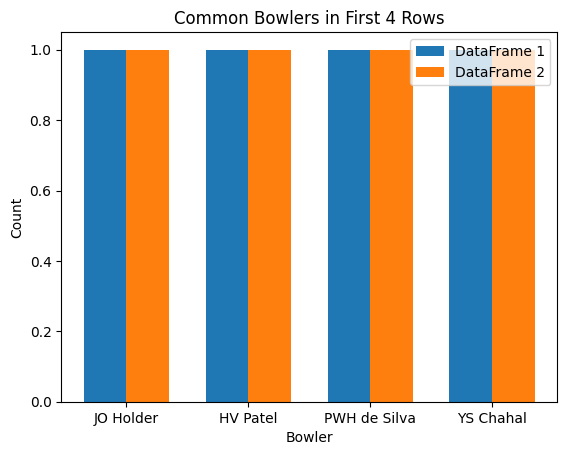

In [157]:
import matplotlib.pyplot as plt

# Assuming df1 and df2 are your two DataFrames
bowlers_df1 = df_res.head(4)["bowler"].tolist()
bowlers_df2 = test_result.head(4)["bowler"].tolist()

bar_width = 0.35  # width of the bars

index = range(len(bowlers_df1))

fig, ax = plt.subplots()
bar1 = ax.bar(index, [1] * len(bowlers_df1), bar_width, label="DataFrame 1")
bar2 = ax.bar(
    [i + bar_width for i in index],
    [1] * len(bowlers_df2),
    bar_width,
    label="DataFrame 2",
)

ax.set_xlabel("Bowler")
ax.set_ylabel("Count")
ax.set_title("Common Bowlers in First 4 Rows")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(bowlers_df1)  # Use bowlers_df1 or bowlers_df2, as needed
ax.legend()

plt.show()